### Radiography and CT Images Neural Network Classification

In [17]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Rescaling, GlobalAveragePooling2D 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Made random seed for conisistency and reproducibility
np.random.seed(42)


In [3]:
# mount to google drive
from google.colab import drive
drive.mount('/content/drive')


 
 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

# Made the training images from the CT Images Radiography Dataset

  
train_ds = image_dataset_from_directory(
    directory = '/content/drive/MyDrive/Colab Notebooks/CT Images/Radiography/COVID-19_Radiography_Dataset',
    image_size=(224,224),
    batch_size=32,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='training',
)



Found 21165 files belonging to 4 classes.
Using 19049 files for training.


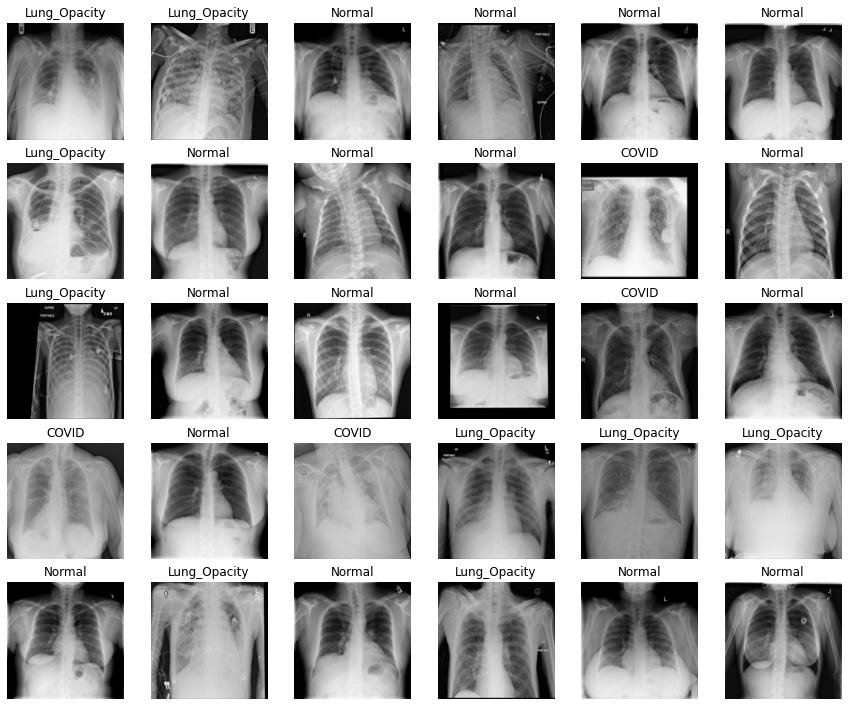

In [5]:
# Got the class names for train image dataset in a variable
class_names = train_ds.class_names

# Made figure to show the images for the 4 classes
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(30):
    ax = plt.subplot(6,6 , i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

These grayscaled images show the 4 different clases from the COVID-19 Radiography CT Images Dataset. The 4 classes are Lung Opacity, COVID, Viral Pneumonia, and Normal. 

In [6]:
# Create the validation set
val_ds = image_dataset_from_directory(
    directory = '/content/drive/MyDrive/Colab Notebooks/CT Images/Radiography/COVID-19_Radiography_Dataset',
    image_size=(224,224),
    batch_size=32,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='validation',
)

Found 21165 files belonging to 4 classes.
Using 2116 files for validation.


In [7]:
# Transfer learning model 

In [8]:
# Instantiate the EfficientNet function
effnet = EfficientNetB0(include_top=False, weights = 'imagenet', input_shape = (224,224,3), classes = 4)

In [9]:
# Set trainable to False
effnet.trainable = False


In [10]:
# Make the transfer learning model
model_t = Sequential()
model_t.add(effnet)
model_t.add(GlobalAveragePooling2D())
model_t.add(Dense(64, activation='relu'))
model_t.add(Dense(4,activation='softmax'))


In [11]:
# Compile the model
model_t.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [12]:
# Get the model summary
model_t.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 4,131,815
Trainable params: 82,244
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
# Fit the model
history2 = model_t.fit(train_ds, 
                     validation_data=val_ds,
                     epochs = 10
          )

Epoch 1/10
596/596 [==============================] - 27s 31ms/step - loss: 0.4294 - acc: 0.8383 - val_loss: 0.3473 - val_acc: 0.8738
Epoch 2/10
596/596 [==============================] - 17s 29ms/step - loss: 0.3079 - acc: 0.8861 - val_loss: 0.3038 - val_acc: 0.8833
Epoch 3/10
596/596 [==============================] - 17s 28ms/step - loss: 0.2785 - acc: 0.8963 - val_loss: 0.2868 - val_acc: 0.8922
Epoch 4/10
596/596 [==============================] - 17s 28ms/step - loss: 0.2548 - acc: 0.9061 - val_loss: 0.2690 - val_acc: 0.8970
Epoch 5/10
596/596 [==============================] - 17s 29ms/step - loss: 0.2354 - acc: 0.9113 - val_loss: 0.3245 - val_acc: 0.8852
Epoch 6/10
596/596 [==============================] - 18s 30ms/step - loss: 0.2257 - acc: 0.9173 - val_loss: 0.2641 - val_acc: 0.9008
Epoch 7/10
596/596 [==============================] - 17s 29ms/step - loss: 0.2180 - acc: 0.9199 - val_loss: 0.2564 - val_acc: 0.9017
Epoch 8/10
596/596 [==============================] - 17s 28ms

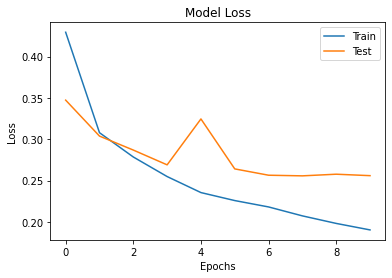

In [14]:
# Plot loss and Validation loss
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history2.history['loss'], label = 'Train')
plt.plot(history2.history['val_loss'], label = 'Test')
plt.legend();
plt.savefig('loss_saved.jpeg')    


The transfer learning training loss showed a negative correlation. The loss kept going down as the epochs increased. The validation loss showed the start of a similar trend but did not dip below 0.25 and started to increase the amount of loss after 8 epochs.  

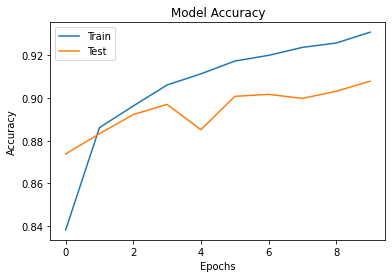

In [15]:
# Plot accuracy and Validation accuracy
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history2.history['acc'], label = 'Train')
plt.plot(history2.history['val_acc'], label = 'Test')
plt.legend();
plt.savefig('acc_saved.jpeg')    


The plot above shows that the model was overfit. After 1 epoch it delineated from the test set. The transfer learning model' training accuracy was over 92% but the validation accuracy capped at around 90%. 





In [18]:
pred_list = []  # store predicted labels
true_list = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds: 
   # append true labels
   true_list.append(label_batch)
   # compute predictions
   preds = model_t.predict(image_batch)
   # append predicted labels
   pred_list.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_classes = tf.concat([item for item in true_list], axis = 0)
predicted_classes = tf.concat([item for item in pred_list], axis = 0)

1/1 [==============================] - 1s 1s/step


In [19]:
# Make confusion matrix
print('Confusion Matrix')
print(confusion_matrix(correct_classes, predicted_classes)) 

Confusion Matrix
[[325  11  20   1]
 [  6 535  72   1]
 [  7  57 921   6]
 [  0   1  13 140]]


The confusion matrix shows that Covid and Viral Pneumonia had the highest amount of true positives. It also shows how randomized the classifications are for Normal and Lung Opacity as there predictions are scattered.

In [20]:
# Made the metrics summary 
print('\nClassification Report\n')
print(classification_report(correct_classes, predicted_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4']))


Classification Report

              precision    recall  f1-score   support

     Class 1       0.96      0.91      0.94       357
     Class 2       0.89      0.87      0.88       614
     Class 3       0.90      0.93      0.91       991
     Class 4       0.95      0.91      0.93       154

    accuracy                           0.91      2116
   macro avg       0.92      0.91      0.91      2116
weighted avg       0.91      0.91      0.91      2116



Class 1 = Covid

Class 2 = Lung Opacity

Class 3 = Normal

Class 4 = Viral Pneumonia

Covid and Viral Pneumonia had the highest precision and f1-scores out of the four. Normal and Lung Opacity were the two lowest. Support shows how imbalanced the data is as Normal and Lung Opacity had the highest amount of support. This could be an indicator of why the precision and f1-score of Normal and Lung Opacity were lower. 